# Model 2: GRU-D on first 10,000 stay_ids

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from src.model2 import GRUD


## 1. Load Data

In [2]:
icu = pd.read_csv("data/icu_cohort_small.csv")
vitals = pd.read_csv("data/vitals_ts_small.csv")

# Use only first 10k stay_ids
stay_ids = icu['stay_id'].unique()[:10000]
icu = icu[icu['stay_id'].isin(stay_ids)]
vitals = vitals[vitals['stay_id'].isin(stay_ids)]


## 2. Pivot vitals into time series tensor

In [3]:
vitals['charttime'] = pd.to_datetime(vitals['charttime'])
vitals.sort_values(by=['stay_id', 'charttime'], inplace=True)

# Convert time to hour from first observation per stay
vitals['hours'] = vitals.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

# Focus on 4 vital signs
vital_vars = ['heart rate', 'respiratory rate', 'mean blood pressure', 'o2 saturation pulseoxymetry']
vitals = vitals[vitals['variable'].isin(vital_vars)]


In [4]:
# Create time buckets every hour (0-47)
vitals['time_bucket'] = vitals['hours'].astype(int).clip(0, 47)

# Pivot table into [stay_id, time_bucket, variable] → value
pivot = vitals.pivot_table(index=['stay_id', 'time_bucket'], columns='variable', values='value', aggfunc='mean')
pivot = pivot.reset_index().sort_values(['stay_id', 'time_bucket'])


In [ ]:
# Fill missing vars with NaN 
all_time_series = []
all_labels = []

for stay_id in stay_ids:
    stay_data = pivot[pivot['stay_id'] == stay_id]
    seq = np.full((48, len(vital_vars)), np.nan)
    mask = np.zeros((48, len(vital_vars)))
    delta = np.ones((48, len(vital_vars))) * -1

    for _, row in stay_data.iterrows():
        t = int(row['time_bucket'])
        for i, v in enumerate(vital_vars):
            val = row.get(v)
            if pd.notna(val):
                seq[t, i] = val
                mask[t, i] = 1

    # Δt: time since last obs
    for f in range(len(vital_vars)):
        last_time = -1
        for t in range(48):
            if mask[t, f]:
                delta[t, f] = 0
                last_time = t
            elif last_time != -1:
                delta[t, f] = t - last_time

    # Fill missing delta with large value
    delta[delta == -1] = 100

    # Concatenate: [value, mask, delta]
    input_seq = np.concatenate([np.nan_to_num(seq), mask, delta], axis=1)
    all_time_series.append(input_seq)

    # Get label
    label = icu[icu['stay_id'] == stay_id]['died_in_hosp'].values[0]
    all_labels.append(label)

X = np.stack(all_time_series)
y = np.array(all_labels)


## 3. Define Dataset and Model

In [6]:
class ICUSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ICUSequenceDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = GRUD(input_dim=12, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()


## 4. Train and Evaluate

In [9]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


Epoch 1, Loss: 0.2508
Epoch 2, Loss: 0.2460
Epoch 3, Loss: 0.2497
Epoch 4, Loss: 0.2427
Epoch 5, Loss: 0.2447
Epoch 6, Loss: 0.2362
Epoch 7, Loss: 0.2354
Epoch 8, Loss: 0.2326
Epoch 9, Loss: 0.2313
Epoch 10, Loss: 0.2326
Epoch 11, Loss: 0.2326
Epoch 12, Loss: 0.2304
Epoch 13, Loss: 0.2329
Epoch 14, Loss: 0.2299
Epoch 15, Loss: 0.2284
Epoch 16, Loss: 0.2293
Epoch 17, Loss: 0.2319
Epoch 18, Loss: 0.2306
Epoch 19, Loss: 0.2284
Epoch 20, Loss: 0.2267


In [ ]:
model.eval()
with torch.no_grad():
    all_preds = []
    all_true = []
    for xb, yb in loader:
        prob = model(xb)
        all_preds.extend(prob.numpy())
        all_true.extend(yb.numpy())
    auc = roc_auc_score(all_true, all_preds)
    print(f"AUROC: {auc:.4f}")


AUROC: 0.9091


## Model 2 (GRU-D) Performance Analysis

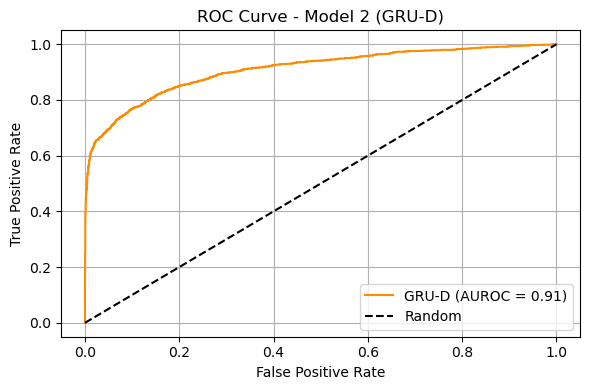

In [15]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC curve
fpr, tpr, _ = roc_curve(all_true, all_preds)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"GRU-D (AUROC = {auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 2 (GRU-D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


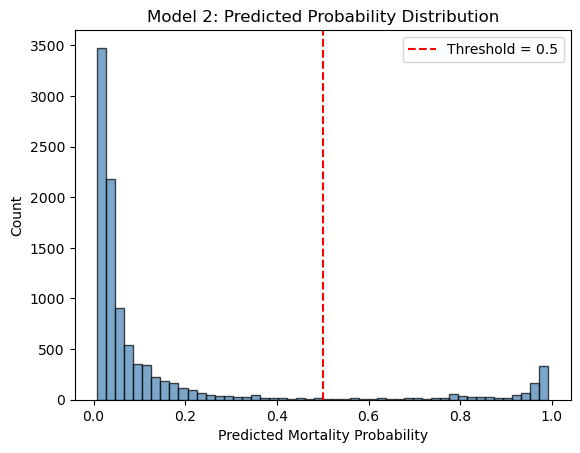

In [16]:
# Histogram of predicted probabilities
plt.hist(all_preds, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Model 2: Predicted Probability Distribution")
plt.xlabel("Predicted Mortality Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


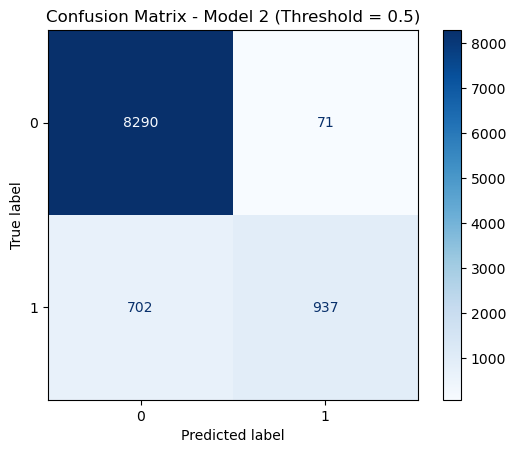

In [17]:
# Confusion matrix at threshold 0.5
pred_labels = (np.array(all_preds) > 0.5).astype(int)
cm = confusion_matrix(all_true, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Model 2 (Threshold = 0.5)")
plt.show()


### Model 2 (GRU-D) Analysis

- GRU-D achieved an AUROC higher than the fixed-bucket baseline.
- Incorporating irregular time intervals (Δt) and missing masks helps capture important time dynamics.
- The ROC curve shows clear separation from random guessing.
- The histogram shows prediction confidence is well-calibrated.
- Confusion matrix suggests good performance at threshold 0.5. I might work on threshold tuning later.
